In [38]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import signal
from scipy.optimize import curve_fit
from scipy import stats
import pickle
from elephant.signal_processing import wavelet_transform
from elephant.spectral import welch_psd
from matplotlib.patches import Rectangle
import time
import seaborn as sns
sns.set_theme()

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.visualization import plot_running_speed

In [39]:
output_dir = Path.home() / 'Desktop' / 'disk2' / 'ecephys_data'
cache = EcephysProjectCache.from_warehouse(manifest=output_dir / 'manifest.json')
channel_df = cache.get_channels()
probes_df = cache.get_probes()

In [40]:
with open('VISpm_VISp_probes.pkl', 'rb') as f:
    probe_list = pickle.load(f)

probe_dict = {e[0]: [e[1], e[2]] for e in probe_list}    
print('{session_id: [VISpm/VISp_probe_1, VISpm/VISp_probe_2]}')
probe_dict

{session_id: [VISpm/VISp_probe_1, VISpm/VISp_probe_2]}


{719161530: [729445650, 729445652],
 732592105: [733744647, 733744649],
 754312389: [756781555, 756781557],
 750332458: [757904547, 757904550],
 751348571: [757984818, 757984820],
 737581020: [757988389, 757988391],
 756029989: [760640087, 760640090],
 755434585: [760642624, 760642628],
 761418226: [768908582, 768908585],
 742951821: [769322714, 769322716],
 759883607: [769322789, 769322793],
 750749662: [769322804, 769322806],
 760693773: [769322824, 769322827],
 758798717: [770930071, 770930073],
 767871931: [773462990, 773462993],
 771160300: [773621939, 773621942],
 771990200: [773654726, 773654728],
 778240327: [792607547, 792607549],
 786091066: [792623919, 792623921],
 778998620: [792626844, 792626847],
 779839471: [792645493, 792645497],
 791319847: [805008602, 805008604],
 797828357: [805579738, 805579741],
 760345702: [810753197, 810753199],
 715093703: [810755799, 810755801],
 794812542: [810758779, 810758781],
 821695405: [822645895, 822645897],
 831882777: [832810576, 8328

In [41]:
# Loading the selected session and determining which probe is VISpm/VISp
session_id = 715093703
selected_session_list = probe_dict[session_id]

session = cache.get_session_data(session_id)

if 'VISpm' in probes_df[probes_df.index==selected_session_list[0]].ecephys_structure_acronyms.item():
    selected_VISpm_probe_id = selected_session_list[0]
    selected_VISp_probe_id = selected_session_list[1]
else:
    selected_VISpm_probe_id = selected_session_list[1]
    selected_VISp_probe_id = selected_session_list[0]

In [42]:
t1 = time.time()
VISpm_lfp = session.get_lfp(selected_VISpm_probe_id)
print(f'LFP data loaded in {time.time()-t1} seconds.')
t1 = time.time()
VISp_lfp = session.get_lfp(selected_VISp_probe_id)
print(f'LFP data loaded in {time.time()-t1} seconds.')
VISp_lfp

LFP data loaded in 27.727807760238647 seconds.
LFP data loaded in 23.98854351043701 seconds.


<xarray.DataArray 'LFP' (time: 11070604, channel: 95)>
array([[-3.7049998e-05, -4.1535000e-05, -5.5184999e-05, ...,
         2.1450001e-06, -3.1200000e-06, -1.5600000e-06],
       [ 1.6185000e-05, -2.1840000e-05, -4.1924999e-05, ...,
        -1.3650000e-06,  1.3650000e-06, -3.9000001e-06],
       [ 3.0224999e-05,  8.1899998e-06, -2.0084999e-05, ...,
         7.2150001e-06, -9.9449999e-06, -5.6549998e-06],
       ...,
       [ 3.0498000e-04,  3.2350500e-04,  2.9328000e-04, ...,
         5.8500000e-06,  2.4569999e-05, -4.0560000e-05],
       [ 2.1235499e-04,  2.6305500e-04,  2.5740001e-04, ...,
         5.0700000e-06,  2.6129999e-05, -4.1730000e-05],
       [ 1.6165500e-04,  1.8973500e-04,  1.7218500e-04, ...,
         7.7999999e-07,  8.5800002e-06, -1.6380000e-05]], dtype=float32)
Coordinates:
  * time     (time) float64 26.88 26.89 26.89 ... 9.578e+03 9.578e+03 9.578e+03
  * channel  (channel) int64 850261198 850261206 ... 850261942 850261950

In [43]:
stim_epochs = session.get_stimulus_epochs()
stim_epochs

,start_time,stop_time,duration,stimulus_name,stimulus_block
0,13.470683,73.537433,60.066750,spontaneous,null
1,73.537433,985.532551,911.995118,gabors,0.0
2,985.532551,1274.523973,288.991422,spontaneous,null
3,1274.523973,1573.023407,298.499434,flashes,1.0
4,1573.023407,1574.774823,1.751416,spontaneous,null
5,1574.774823,2174.275707,599.500885,drifting_gratings,2.0
6,2174.275707,2205.301633,31.025925,spontaneous,null
7,2205.301633,2805.836653,600.535020,natural_movie_three,3.0
8,2805.836653,2835.861733,30.025080,spontaneous,null
9,2835.861733,3136.112583,300.250850,natural_movie_one,4.0


In [44]:
stim_flashes = session.get_stimulus_table(['flashes'])

In [45]:
flash_times = stim_flashes[['stimulus_condition_id','start_time','stop_time']].to_numpy()
flash_times.shape

(150, 3)

In [46]:
# Putting flash_times array into another format for plotting
temp_array = []
for i in range(flash_times.shape[0]):
    if flash_times[i,0]==244: val = -1
    else: val = 1
    temp_array.append([flash_times[i,1],0])
    temp_array.append([flash_times[i,1],val])
    temp_array.append([flash_times[i,2],val])
    temp_array.append([flash_times[i,2],0])
plot_format_flash_times = np.array(temp_array)

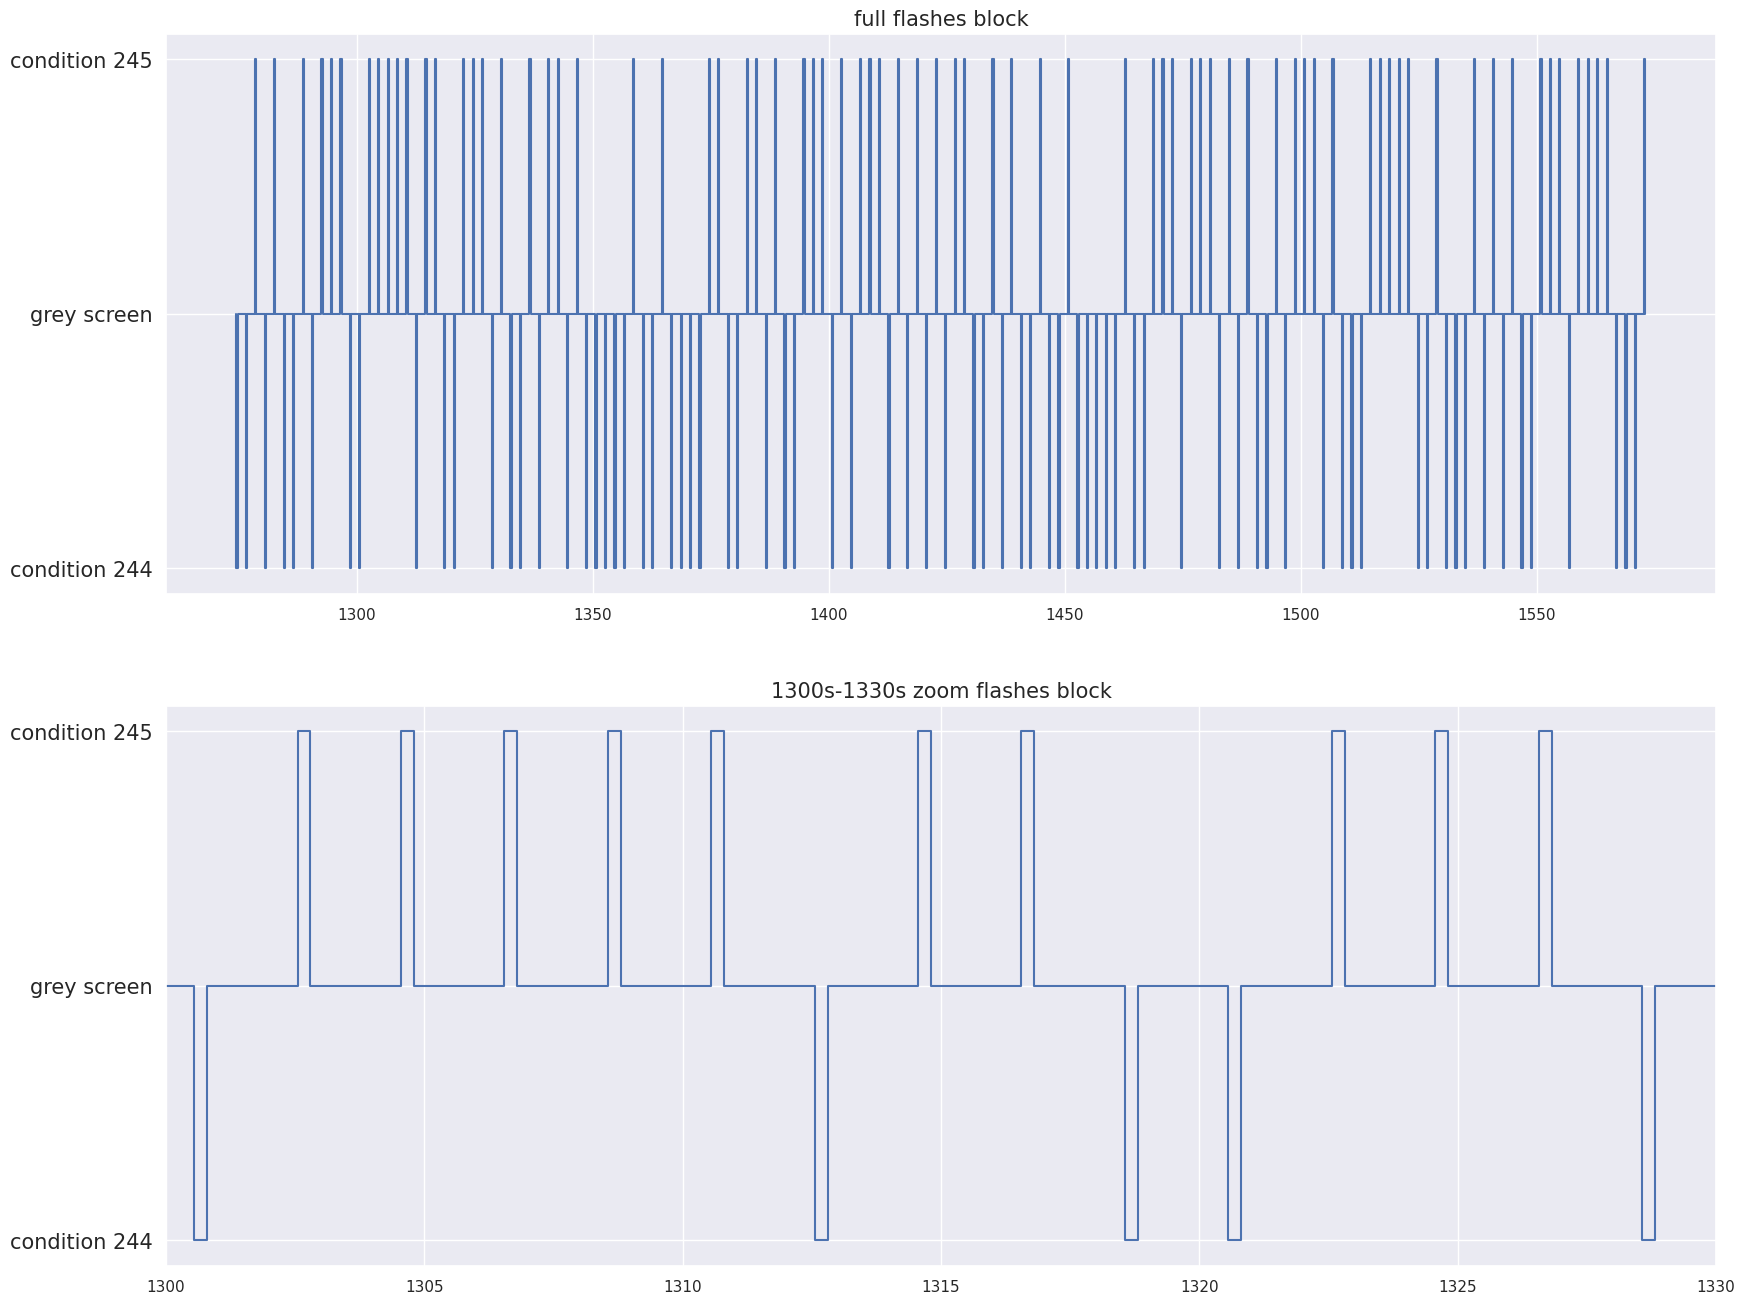

In [47]:
fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(20,16))

ax[0].set_title('full flashes block',fontsize=15)
ax[0].set_yticks([-1,0,1])
ax[0].set_yticklabels(['condition 244','grey screen','condition 245'],fontsize=15)
ax[0].plot(plot_format_flash_times[:,0],plot_format_flash_times[:,1])

ax[1].set_title('1300s-1330s zoom flashes block',fontsize=15)
ax[1].set_yticks([-1,0,1])
ax[1].set_yticklabels(['condition 244','grey screen','condition 245'],fontsize=15)
ax[1].plot(plot_format_flash_times[:,0],plot_format_flash_times[:,1])
ax[1].set_xlim([1300,1330])

plt.show()

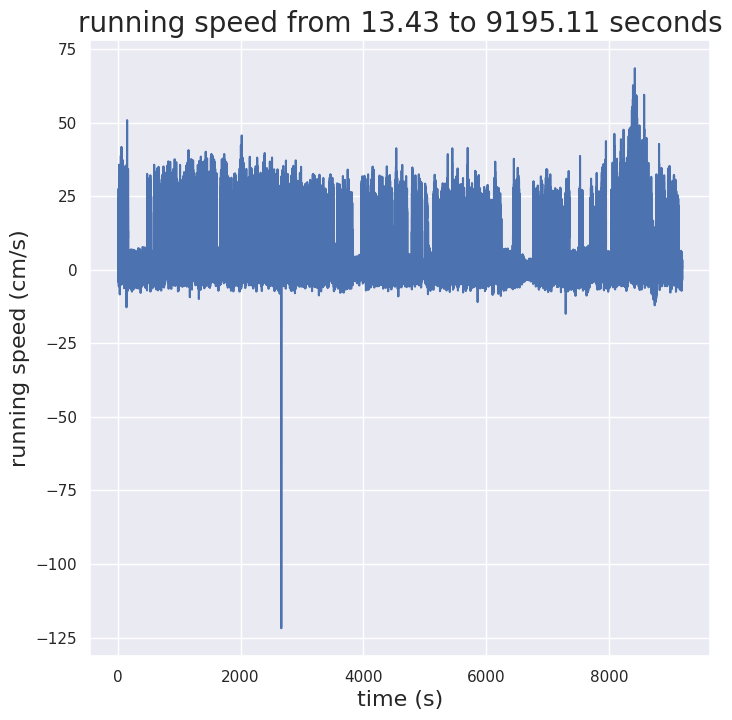

In [48]:
running_speed_midpoints = session.running_speed["start_time"] + (session.running_speed["end_time"] - session.running_speed["start_time"]) / 2
plot_running_speed(
    running_speed_midpoints, 
    session.running_speed["velocity"], 
    start_index=0,
    stop_index=session.running_speed.shape[0]
)
plt.show()

In [49]:
time_velocity_df = pd.concat([running_speed_midpoints, session.running_speed["velocity"]],axis=1,keys=['running_speed_midpoint','velocity'])
time_velocity_df

,running_speed_midpoint,velocity
0,13.426940,23.570796
1,13.459740,14.813276
2,13.476405,14.352495
3,13.509725,16.674026
4,13.526425,16.747644
...,...,...
366031,9195.012540,0.540036
366032,9195.045945,1.681892
366033,9195.062805,-1.833893
366034,9195.096245,1.990784


In [50]:
VISpm_lfp.sel(channel=850263332).sel(time=slice(800,1000)).data

array([-2.5740e-05, -1.3650e-06,  2.2815e-05, ..., -3.3150e-05,
       -2.2035e-05, -3.9000e-07], dtype=float32)

In [51]:
mid_time = stim_epochs[stim_epochs.stimulus_name=='flashes'].start_time.item()

In [52]:
# plot_format_flash_times
# time_velocity_df
# VISpm_lfp.sel(channel=850262740).sel(time=slice(800,1000))

In [53]:
ADD_TO_MIDPOINT = 14.2

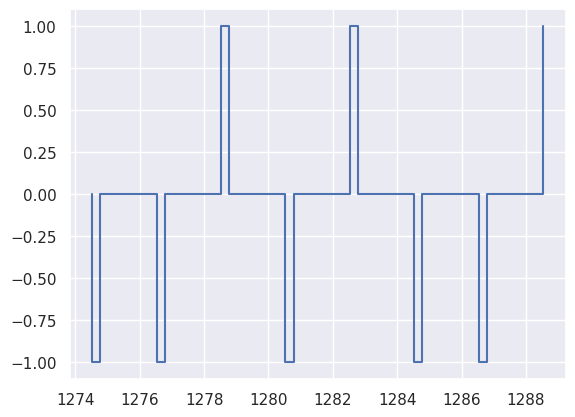

In [54]:
inds = np.where((plot_format_flash_times[:,0] >= mid_time) & (plot_format_flash_times[:,0] < mid_time+ADD_TO_MIDPOINT))[0]
plt.plot(plot_format_flash_times[inds,0], plot_format_flash_times[inds,1])

In [55]:
plot_format_flash_times[inds,0]

array([1274.52397294, 1274.52397294, 1274.77418908, 1274.77418908,
       1276.52562294, 1276.52562294, 1276.77584158, 1276.77584158,
       1278.52734294, 1278.52734294, 1278.77755158, 1278.77755158,
       1280.52901294, 1280.52901294, 1280.77922158, 1280.77922158,
       1282.53072294, 1282.53072294, 1282.78092408, 1282.78092408,
       1284.53232294, 1284.53232294, 1284.78253908, 1284.78253908,
       1286.53401294, 1286.53401294, 1286.78422908, 1286.78422908,
       1288.53570294, 1288.53570294])

In [56]:
temp_arr = np.linspace(mid_time-ADD_TO_MIDPOINT, plot_format_flash_times[inds,0][0], plot_format_flash_times[inds,0].shape[0])
zero_arr = np.array([temp_arr, np.zeros_like(temp_arr)]).T
zero_arr

array([[1260.32397294,    0.        ],
       [1260.81362811,    0.        ],
       [1261.30328328,    0.        ],
       [1261.79293845,    0.        ],
       [1262.28259363,    0.        ],
       [1262.7722488 ,    0.        ],
       [1263.26190397,    0.        ],
       [1263.75155914,    0.        ],
       [1264.24121432,    0.        ],
       [1264.73086949,    0.        ],
       [1265.22052466,    0.        ],
       [1265.71017983,    0.        ],
       [1266.19983501,    0.        ],
       [1266.68949018,    0.        ],
       [1267.17914535,    0.        ],
       [1267.66880052,    0.        ],
       [1268.1584557 ,    0.        ],
       [1268.64811087,    0.        ],
       [1269.13776604,    0.        ],
       [1269.62742121,    0.        ],
       [1270.11707638,    0.        ],
       [1270.60673156,    0.        ],
       [1271.09638673,    0.        ],
       [1271.5860419 ,    0.        ],
       [1272.07569707,    0.        ],
       [1272.56535225,   

In [57]:
zero_arr.shape

(30, 2)

In [58]:
concat_plot_arr = np.concatenate((zero_arr, plot_format_flash_times[inds]), axis=0)
concat_plot_arr.shape

(60, 2)

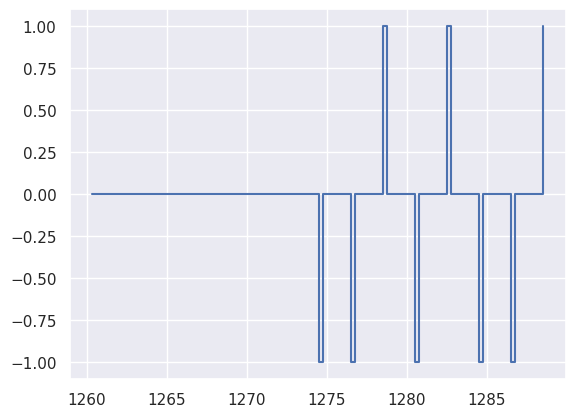

In [59]:
plt.plot(concat_plot_arr[:,0], concat_plot_arr[:,1])

In [60]:
velocity_arr = time_velocity_df[(time_velocity_df.running_speed_midpoint >= mid_time-ADD_TO_MIDPOINT) & (time_velocity_df.running_speed_midpoint < mid_time+ADD_TO_MIDPOINT)].velocity.values

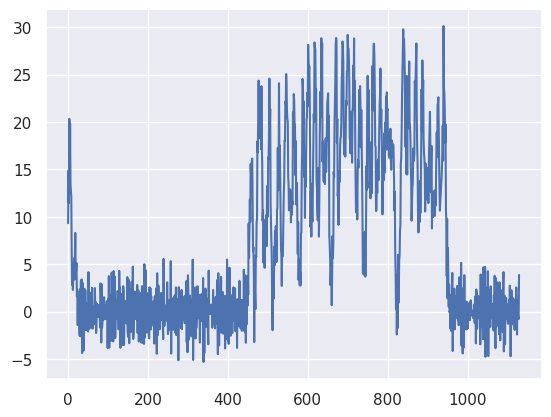

In [61]:
plt.plot(velocity_arr)

In [62]:
lfp_arr = VISpm_lfp.sel(channel=850263332).sel(time=slice(mid_time-ADD_TO_MIDPOINT, mid_time+ADD_TO_MIDPOINT)).data
lfp_arr.shape

(35500,)

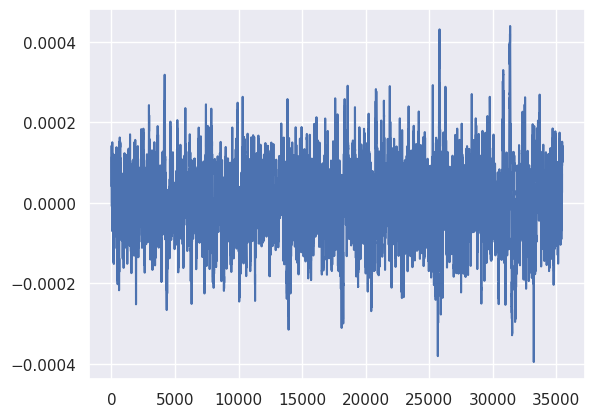

In [63]:
plt.plot(lfp_arr)

In [64]:
with open('chosen_velocity_thresholds.pkl', 'rb') as f:
    chosen_thresholds = pickle.load(f)

In [65]:
chosen_thresholds[session_id]

5.34137221579163

In [66]:
def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = signal.butter(order, cutoff, fs=fs, btype='low', analog=False)
    y = signal.lfilter(b, a, data)
    return y

In [67]:
time_velocity_df

,running_speed_midpoint,velocity
0,13.426940,23.570796
1,13.459740,14.813276
2,13.476405,14.352495
3,13.509725,16.674026
4,13.526425,16.747644
...,...,...
366031,9195.012540,0.540036
366032,9195.045945,1.681892
366033,9195.062805,-1.833893
366034,9195.096245,1.990784


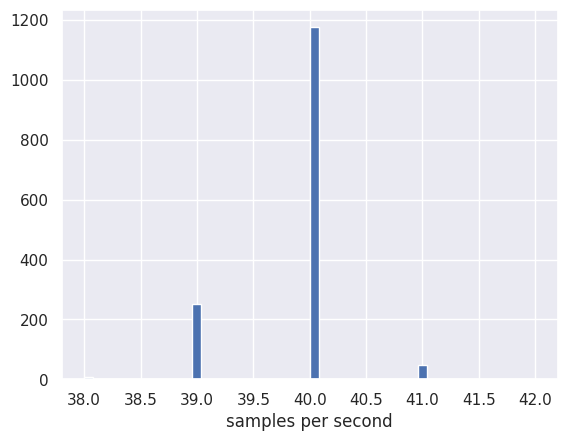

In [68]:
l = []
for i in range(14, 1500):
    l.append(time_velocity_df[(time_velocity_df.running_speed_midpoint >= i) & (time_velocity_df.running_speed_midpoint < i+1)].shape[0])
plt.hist(l,bins=50)
plt.xlabel('samples per second')
plt.show()
# ~40Hz sampling rate of velocity

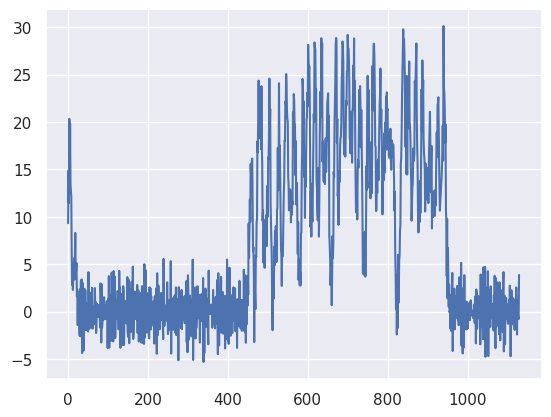

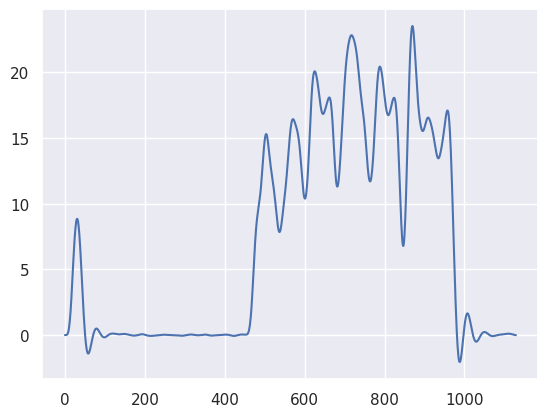

In [69]:
plt.plot(velocity_arr)
plt.show()
plt.plot(butter_lowpass_filter(velocity_arr, 1, 40))
plt.show()

In [70]:
concat_plot_arr[:,0]

array([1260.32397294, 1260.81362811, 1261.30328328, 1261.79293845,
       1262.28259363, 1262.7722488 , 1263.26190397, 1263.75155914,
       1264.24121432, 1264.73086949, 1265.22052466, 1265.71017983,
       1266.19983501, 1266.68949018, 1267.17914535, 1267.66880052,
       1268.1584557 , 1268.64811087, 1269.13776604, 1269.62742121,
       1270.11707638, 1270.60673156, 1271.09638673, 1271.5860419 ,
       1272.07569707, 1272.56535225, 1273.05500742, 1273.54466259,
       1274.03431776, 1274.52397294, 1274.52397294, 1274.52397294,
       1274.77418908, 1274.77418908, 1276.52562294, 1276.52562294,
       1276.77584158, 1276.77584158, 1278.52734294, 1278.52734294,
       1278.77755158, 1278.77755158, 1280.52901294, 1280.52901294,
       1280.77922158, 1280.77922158, 1282.53072294, 1282.53072294,
       1282.78092408, 1282.78092408, 1284.53232294, 1284.53232294,
       1284.78253908, 1284.78253908, 1286.53401294, 1286.53401294,
       1286.78422908, 1286.78422908, 1288.53570294, 1288.53570

In [71]:
xlims = [concat_plot_arr[:,0][0], concat_plot_arr[:,0][-1]]

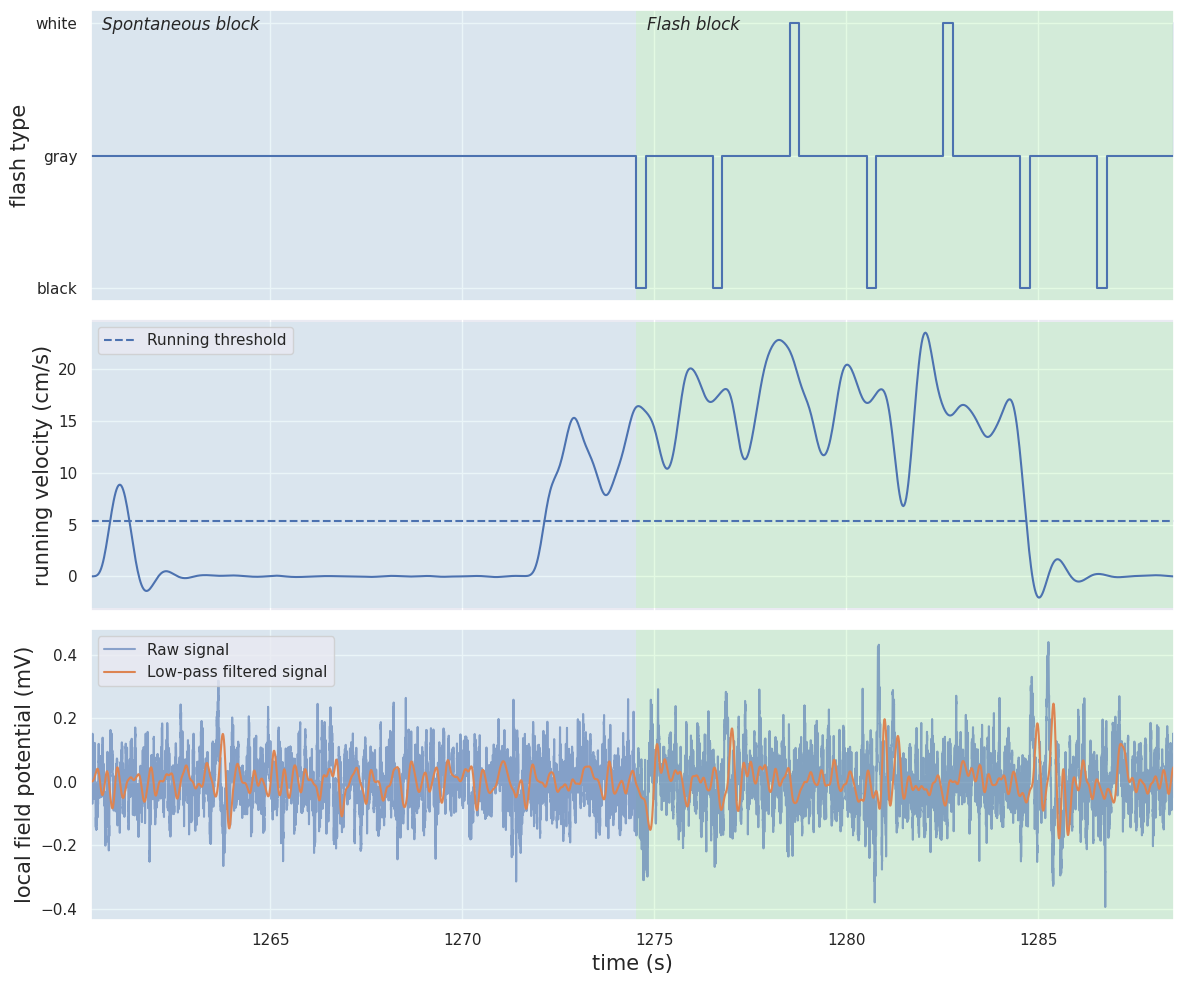

In [72]:
fig, ax = plt.subplots(nrows=3,ncols=1, figsize=(12,10))

ax[0].plot(concat_plot_arr[:,0], concat_plot_arr[:,1])
ax[0].tick_params(axis='both', which='both', bottom=False, labelbottom=False)
ax[0].set_yticks([-1,0,1])
ax[0].set_yticklabels(['black','gray','white'])
ax[0].set_ylabel('flash type', fontsize=15)
ax[0].set_xlim(xlims)
ax[0].add_patch(Rectangle((concat_plot_arr[:,0][0],-1.1), mid_time-concat_plot_arr[:,0][0], 2.2, edgecolor='none',facecolor='lightblue', alpha=0.25))
ax[0].add_patch(Rectangle((mid_time,-1.1), concat_plot_arr[:,0][-1]-mid_time, 2.2, edgecolor='none',facecolor='lightgreen', alpha=0.25))
ax[0].text(concat_plot_arr[:,0][0]+0.3, 0.95, 'Spontaneous block', fontstyle='italic')
ax[0].text(mid_time+0.3, 0.95, 'Flash block', fontstyle='italic')

t = np.linspace(concat_plot_arr[:,0][0], concat_plot_arr[:,0][-1], velocity_arr.shape[0])
ax[1].plot(t, butter_lowpass_filter(velocity_arr, 1, 40), label='_nolegend_')
ax[1].axhline(chosen_thresholds[session_id], linestyle='--')
ax[1].legend(['Running threshold'], loc='upper left')
ax[1].tick_params(axis='both', which='both', bottom=False, labelbottom=False)
ax[1].set_ylabel('running velocity (cm/s)', fontsize=15)
ax[1].set_xlim(xlims)
min_v = butter_lowpass_filter(velocity_arr, 1, 40).min()-1
max_v = butter_lowpass_filter(velocity_arr, 1, 40).max()+1
ax[1].add_patch(Rectangle((concat_plot_arr[:,0][0], min_v), mid_time-concat_plot_arr[:,0][0], max_v-min_v, edgecolor='none',facecolor='lightblue', alpha=0.25))
ax[1].add_patch(Rectangle((mid_time, min_v), concat_plot_arr[:,0][-1]-mid_time, max_v-min_v, edgecolor='none',facecolor='lightgreen', alpha=0.25))

t = np.linspace(concat_plot_arr[:,0][0], concat_plot_arr[:,0][-1], lfp_arr.shape[0])
mV_lfp_arr = lfp_arr * 1000 # convert to mV
ax[2].plot(t,mV_lfp_arr, alpha=0.6)
ax[2].plot(t,butter_lowpass_filter(mV_lfp_arr, 4, 1250))
ax[2].set_ylabel('local field potential (mV)', fontsize=15)
ax[2].set_xlim(xlims)
ax[2].legend(['Raw signal', 'Low-pass filtered signal'], loc='upper left')
old_ylims = ax[2].get_ylim()
min_lfp = mV_lfp_arr.min()-1
max_lfp = mV_lfp_arr.max()+1
ax[2].add_patch(Rectangle((concat_plot_arr[:,0][0], min_lfp), mid_time-concat_plot_arr[:,0][0], max_lfp-min_lfp, edgecolor='none',facecolor='lightblue', alpha=0.25))
ax[2].add_patch(Rectangle((mid_time, min_lfp), concat_plot_arr[:,0][-1]-mid_time, max_lfp-min_lfp, edgecolor='none',facecolor='lightgreen', alpha=0.25))
ax[2].set_ylim(old_ylims)
ax[2].set_xlabel('time (s)', fontsize=15)

plt.tight_layout()
plt.savefig('flash_illustration.png')
plt.show()